In [4]:
library(mltools)
library(data.table)
library(lsa)
library(aricode)
library(kBET)
library(cowplot)
library(ggplot2)
library(mclust)

Loading required package: SnowballC


Attaching package: ‘aricode’


The following object is masked from ‘package:lsa’:

    entropy


Package 'mclust' version 5.4.7
Type 'citation("mclust")' for citing this R package in publications.



In [2]:
seur <- readRDS('/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/5celltype/seur_patient1_BCR-XL.rds')

In [9]:
rst <- readRDS('/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/5celltype/rst_patient1_BCR-XL.rds')

In [10]:
rst$H

"matrix(colnames(A0), ncol = 1)",X1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,X2742,X2743,X2744,X2745,X2746,X2747,X2748,X2749,X2750,X2751
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
naïve B cells,1.401965e-20,9.394162e-44,1.546003e-01,7.878238e-02,4.492856e-02,3.845289e-01,1.481032e-20,2.130327e-20,5.887215e-01,⋯,2.107812e-10,0.1351595318,1.678019e-08,0.0003822888,2.529056e-14,1.645890e-13,7.780065e-10,1.795140e-21,4.690928e-23,1.098089e-01
CD4 T-cells,1.023139e+00,1.062849e+00,6.728391e-06,6.493048e-01,1.382510e-07,3.730896e-07,1.363212e-01,8.797347e-07,3.851361e-06,⋯,3.894783e-03,0.0006505669,3.913865e-04,0.0005547047,7.207559e-03,1.590665e-01,5.028752e-01,9.699897e-01,8.994405e-01,7.132196e-05
CD8 T-cells,3.627743e-04,5.676805e-08,4.904385e-02,2.718223e-01,4.513237e-01,6.337650e-01,8.094852e-01,1.944323e-01,3.653007e-01,⋯,7.610626e-01,0.3761189004,6.200906e-01,0.9171592743,4.403804e-01,3.325920e-01,2.360941e-24,1.807669e-05,1.064539e-01,1.198407e-01
monocytes,2.092126e-20,1.009348e-41,3.786616e-02,3.972721e-02,7.218413e-04,4.568171e-10,3.477819e-21,2.603294e-30,8.166007e-19,⋯,1.712103e-08,0.1628841758,7.991752e-09,0.0020272424,2.574302e-08,9.688078e-02,3.796670e-01,6.091530e-18,2.313405e-28,5.967350e-02
NK cells,2.303204e-15,4.938908e-09,7.824453e-01,6.717331e-27,5.129880e-01,1.589270e-09,7.283551e-02,8.573003e-01,8.651698e-02,⋯,2.452305e-01,0.3220773469,3.899361e-01,0.0815916420,5.528945e-01,4.284566e-01,1.091752e-01,6.419635e-02,3.670852e-02,7.238270e-01


In [12]:
truth <- seur$label
truth_onehot <- as.data.frame(t(one_hot(as.data.table(as.factor(truth)))))

In [13]:
truth_onehot

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V2742,V2743,V2744,V2745,V2746,V2747,V2748,V2749,V2750,V2751
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
V1_CD4 T-cells,1,1,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,1,1,0
V1_CD8 T-cells,0,0,0,0,1,1,1,0,1,1,⋯,1,1,1,1,0,0,0,0,0,0
V1_monocytes,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
V1_naïve B cells,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
V1_NK cells,0,0,1,0,0,0,0,1,0,0,⋯,0,0,0,0,1,1,0,0,0,1


In [15]:
seur_files <- list.files(path = '/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/5celltype', 
                         pattern='*seur*', full=T, ignore.case = TRUE)
rst_files <- list.files(path = '/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/5celltype', 
                        pattern='*rst_patient*', full=T, ignore.case = TRUE)
rst_woas_files <- list.files(path = '/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/5celltype', 
                        pattern='*rst_woa0*', full=T, ignore.case = TRUE)
rst_woa0_files <- list.files(path = '/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/5celltype', 
                        pattern='*rst_woa0*', full=T, ignore.case = TRUE)
rst_woa0as_files <- list.files(path = '/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/5celltype', 
                        pattern='*rst_woa0as*', full=T, ignore.case = TRUE)

In [72]:
acc_vec <- acc_vec_woas <- acc_vec_woa0 <- acc_vec_woa0as <- c()
cos_vec <- cos_vec_woas <- cos_vec_woa0 <- cos_vec_woa0as <-c()
nmi_vec <- nmi_vec_woas <- nmi_vec_woa0 <- nmi_vec_woa0as <- c()
ari_vec <- ari_vec_woas <- ari_vec_woa0 <- ari_vec_woa0as <- c()
sil_vec <- sil_vec_woas <- sil_vec_woa0 <- sil_vec_woa0as <- c()

In [73]:
for(sample.idx in 1:length(rst_files)){
    rst <- readRDS(rst_files[sample.idx])
    rst_woas <- readRDS(rst_woas_files[sample.idx])
    rst_woa0 <- readRDS(rst_woa0_files[sample.idx])
    rst_woa0as <- readRDS(rst_woa0as_files[sample.idx])
    
    seur <- readRDS(seur_files[sample.idx])
    truth <- seur$label
    pred <- seur$pred
    pred_woas <- seur$pred_woas
    pred_woa0 <- seur$pred_woa0
    pred_woa0as <- seur$pred_woa0as
    
    H <- rst$H
    H_woas <- rst_woas$H
    H_woa0 <- rst_woa0$H
    H_woa0as <- rst_woa0as$H
    
    rownames(H) <- H[,1]
    rownames(H_woas) <- H_woas[,1]
    rownames(H_woa0) <- H_woa0[,1]
    rownames(H_woa0as) <- H_woa0as[,1]
    
    H <- H[,-1]
    H_woas <- H_woas[,-1]
    H_woa0 <- H_woa0[,-1]
    H_woa0as <- H_woa0as[,-1]
    
    celltypes <- c('CD4 T-cells', 'CD8 T-cells', 'monocytes', 'naïve B cells', 'NK cells')
    H <- H[celltypes,]
    H_woas <- H_woas[celltypes,]
    H_woa0 <- H_woa0[celltypes,]
    H_woa0as <- H_woa0as[celltypes,]
    
    truth_onehot <- as.data.frame(t(one_hot(as.data.table(as.factor(truth)))))
    pred_fac <- as.factor(pred)
    pred_fac_woas <- as.factor(pred_woas)
    pred_fac_woa0 <- as.factor(pred_woa0)
    pred_fac_woa0as <- as.factor(pred_woa0as)
    pred_onehot <- as.data.frame(t(one_hot(as.data.table(factor(pred_fac, levels = celltypes)))))
    pred_onehot_woas <- as.data.frame(t(one_hot(as.data.table(factor(pred_fac_woas, levels = celltypes)))))
    pred_onehot_woa0 <- as.data.frame(t(one_hot(as.data.table(factor(pred_fac_woa0, levels = celltypes)))))
    pred_onehot_woa0as <- as.data.frame(t(one_hot(as.data.table(factor(pred_fac_woa0as, levels = celltypes)))))
    
    ## raw 
    # Accuracy
    cnt_max <- cnt_max_woas <- cnt_max_woa0 <- cnt_max_woa0as <- 0
    N = ncol(seur)
    for(i in 1:length(truth)){
        cnt_max = cnt_max + 1*(truth[i]==pred[i])
        cnt_max_woas = cnt_max_woas + 1*(truth[i]==pred_woas[i])
        cnt_max_woa0 = cnt_max_woa0 + 1*(truth[i]==pred_woa0[i])
        cnt_max_woa0as = cnt_max_woa0as + 1*(truth[i]==pred_woa0as[i])
    }
    print(paste0(rst_files[sample.idx]," : ", cnt_max))
    print(cnt_max/N)
    acc_vec <- append(acc_vec,cnt_max/N)
    acc_vec_woas <- append(acc_vec_woas,cnt_max_woas/N)
    acc_vec_woa0 <- append(acc_vec_woa0,cnt_max_woa0/N)
    acc_vec_woa0as <- append(acc_vec_woa0as,cnt_max_woa0as/N)
    
    # Cosine similarity
    cos_vec <- append(cos_vec, mean(mapply(cosine, truth_onehot, as.data.frame(H))))
    cos_vec_woas <- append(cos_vec_woas, mean(mapply(cosine, truth_onehot, as.data.frame(H_woas))))
    cos_vec_woa0 <- append(cos_vec_woa0, mean(mapply(cosine, truth_onehot, as.data.frame(H_woa0))))
    cos_vec_woa0as <- append(cos_vec_woa0as, mean(mapply(cosine, truth_onehot, as.data.frame(H_woa0as))))
    
    # NMI
    nmi_vec <- append(nmi_vec, mean(mapply(NMI, truth_onehot, as.data.frame(pred_onehot))))
    nmi_vec_woas <- append(nmi_vec_woas, mean(mapply(NMI, truth_onehot, as.data.frame(pred_onehot_woas))))
    nmi_vec_woa0 <- append(nmi_vec_woa0, mean(mapply(NMI, truth_onehot, as.data.frame(pred_onehot_woa0))))
    nmi_vec_woa0as <- append(nmi_vec_woa0as, mean(mapply(NMI, truth_onehot, as.data.frame(pred_onehot_woa0as))))
    
    # ARI
    ari_vec <- append(ari_vec, adjustedRandIndex(pred, truth))
    ari_vec_woas <- append(ari_vec_woas, adjustedRandIndex(pred_woas, truth))
    ari_vec_woa0 <- append(ari_vec_woa0, adjustedRandIndex(pred_woa0, truth))
    ari_vec_woa0as <- append(ari_vec_woa0as, adjustedRandIndex(pred_woa0as, truth))
    
    # Silhouette
    pca.data <- list()
    pca.data$x <- seur@reductions$pca@cell.embeddings
    pca.data_woas <- list()
    pca.data_woas$x <- seur@reductions$pca@cell.embeddings
    pca.data_woa0 <- list()
    pca.data_woa0$x <- seur@reductions$pca@cell.embeddings
    pca.data_woa0as <- list()
    pca.data_woa0as$x <- seur@reductions$pca@cell.embeddings
    
    sil_vec <- append(sil_vec, batch_sil(pca.data, as.numeric(as.factor(pred))))
    sil_vec_woas <- append(sil_vec_woas, batch_sil(pca.data_woas, as.numeric(as.factor(pred_woas))))
    sil_vec_woa0 <- append(sil_vec_woa0, batch_sil(pca.data_woa0, as.numeric(as.factor(pred_woa0))))
    sil_vec_woa0as <- append(sil_vec_woa0as, batch_sil(pca.data_woa0as, as.numeric(as.factor(pred_woa0as))))                                 

    
#     ## subsetting
#     # Accuracy
#     H_est_subsetting <- apply(H,2,function(x) x/sum(x))
#     H_est_subsetting_woas <- apply(H_woas,2,function(x) x/sum(x))
#     H_est_subsetting_woa0 <- apply(H_woa0,2,function(x) x/sum(x))
#     H_est_subsetting_woa0as <- apply(H_woa0as,2,function(x) x/sum(x))
                              
#     cnt_max <- cnt_max_woas <- cnt_max_woa0 <- cnt_max_woa0as <- 0
#     N_subsetting <- N_subsetting_woas <- N_subsetting_woa0 <- N_subsetting_woa0as <- 0
#     idx.subsetting <- idx.subsetting_woas <- idx.subsetting_woa0 <- idx.subsetting_woa0as <- c()
#     for(i in 1:length(truth)){
#         if(max(H_est_subsetting[,i])>0.5){
#             idx.subsetting = append(idx.subsetting,i)
#             N_subsetting = N_subsetting+1
#             cnt_max = cnt_max + 1*(truth[i]==pred[i])
#         }
#         if(max(H_est_subsetting_woas[,i])>0.5){
#             idx.subsetting_woas = append(idx.subsetting_woas,i)
#             N_subsetting_woas = N_subsetting_woas+1
#             cnt_max_woas = cnt_max_woas + 1*(truth[i]==pred_woas[i])
#         }
#         if(max(H_est_subsetting_woa0[,i])>0.5){
#             idx.subsetting_woa0 = append(idx.subsetting_woa0,i)
#             N_subsetting_woa0 = N_subsetting_woa0+1
#             cnt_max_woa0 = cnt_max_woa0 + 1*(truth[i]==pred_woa0[i])
#         }
#         if(max(H_est_subsetting_woa0as[,i])>0.5){
#             idx.subsetting_woa0as = append(idx.subsetting_woa0as,i)
#             N_subsetting_woa0as = N_subsetting_woa0as+1
#             cnt_max_woa0as = cnt_max_woa0as + 1*(truth[i]==pred_woa0as[i])
#         }
#     }
#     cnt_max
#     print(cnt_max/N_subsetting)
#     acc_vec <- append(acc_vec,cnt_max/N_subsetting)
#     acc_vec_woas <- append(acc_vec_woas,cnt_max_woas/N_subsetting_woas)
#     acc_vec_woa0 <- append(acc_vec_woa0,cnt_max_woa0/N_subsetting_woa0)
#     acc_vec_woa0as <- append(acc_vec_woa0as,cnt_max_woa0as/N_subsetting_woa0as)                                 
                              
#     # Cosine similarity
#     truth_sub <- truth[idx.subsetting]
#     truth_fact_sub <- as.factor(truth_sub)
#     truth_onehot_sub <- as.data.frame(t(one_hot(as.data.table(truth_fact_sub))))
#     truth_sub_woas <- truth[idx.subsetting_woas]
#     truth_fact_sub_woas <- as.factor(truth_sub_woas)
#     truth_onehot_sub_woas <- as.data.frame(t(one_hot(as.data.table(truth_fact_sub_woas))))
#     truth_sub_woa0 <- truth[idx.subsetting_woa0]
#     truth_fact_sub_woa0 <- as.factor(truth_sub_woa0)
#     truth_onehot_sub_woa0 <- as.data.frame(t(one_hot(as.data.table(truth_fact_sub_woa0))))
#     truth_sub_woa0as <- truth[idx.subsetting_woa0as]
#     truth_fact_sub_woa0as <- as.factor(truth_sub_woa0as)
#     truth_onehot_sub_woa0as <- as.data.frame(t(one_hot(as.data.table(truth_fact_sub_woa0as))))
                                     
#     cos_vec <- append(cos_vec, mean(mapply(cosine, truth_onehot_sub, 
#                                                          as.data.frame(H_est_subsetting[,idx.subsetting]))))
#     cos_vec_woas <- append(cos_vec_woas, mean(mapply(cosine, truth_onehot_sub_woas, 
#                                                          as.data.frame(H_est_subsetting_woas[,idx.subsetting_woas]))))
#     cos_vec_woa0 <- append(cos_vec_woa0, mean(mapply(cosine, truth_onehot_sub_woa0, 
#                                                          as.data.frame(H_est_subsetting_woa0[,idx.subsetting_woa0]))))
#     cos_vec_woa0as <- append(cos_vec_woa0as, mean(mapply(cosine, truth_onehot_sub_woa0as, 
#                                                          as.data.frame(H_est_subsetting_woa0as[,idx.subsetting_woa0as]))))                                 
#     # NMI
#     celltype_pred_sub <- pred[idx.subsetting]
#     celltype_pred_sub <- as.factor(celltype_pred_sub)
#     celltype_pred_sub <- factor(celltype_pred_sub, levels = levels(truth_fact_sub))
#     celltype_pred_sub_woas <- pred_woas[idx.subsetting_woas]
#     celltype_pred_sub_woas <- as.factor(celltype_pred_sub_woas)
#     celltype_pred_sub_woas <- factor(celltype_pred_sub_woas, levels = levels(truth_fact_sub_woas))
#     celltype_pred_sub_woa0 <- pred_woa0[idx.subsetting_woa0]
#     celltype_pred_sub_woa0 <- as.factor(celltype_pred_sub_woa0)
#     celltype_pred_sub_woa0 <- factor(celltype_pred_sub_woa0, levels = levels(truth_fact_sub_woa0))
#     celltype_pred_sub_woa0as <- pred_woa0as[idx.subsetting_woa0as]
#     celltype_pred_sub_woa0as <- as.factor(celltype_pred_sub_woa0as)
#     celltype_pred_sub_woa0as <- factor(celltype_pred_sub_woa0as, levels = levels(truth_fact_sub_woa0as))                                 
    
#     pred_onehot_sub <- as.data.frame(t(one_hot(as.data.table(as.factor(celltype_pred_sub)))))
#     pred_onehot_sub_woas <- as.data.frame(t(one_hot(as.data.table(as.factor(celltype_pred_sub_woas)))))
#     pred_onehot_sub_woa0 <- as.data.frame(t(one_hot(as.data.table(as.factor(celltype_pred_sub_woa0)))))
#     pred_onehot_sub_woa0as <- as.data.frame(t(one_hot(as.data.table(as.factor(celltype_pred_sub_woa0as)))))
                                     
#     nmi_vec <- append(nmi_vec, mean(mapply(NMI, truth_onehot_sub, pred_onehot_sub)))
#     nmi_vec_woas <- append(nmi_vec_woas, mean(mapply(NMI, truth_onehot_sub_woas, pred_onehot_sub_woas)))
#     nmi_vec_woa0 <- append(nmi_vec_woa0, mean(mapply(NMI, truth_onehot_sub_woa0, pred_onehot_sub_woa0)))
#     nmi_vec_woa0as <- append(nmi_vec_woa0as, mean(mapply(NMI, truth_onehot_sub_woa0as, pred_onehot_sub_woa0as)))                                 
                              
#     # ARI
#     ari_vec <- append(ari_vec, adjustedRandIndex(celltype_pred_sub, truth_sub))
#     ari_vec_woas <- append(ari_vec_woas, adjustedRandIndex(celltype_pred_sub_woas, truth_sub_woas))
#     ari_vec_woa0 <- append(ari_vec_woa0, adjustedRandIndex(celltype_pred_sub_woa0, truth_sub_woa0))
#     ari_vec_woa0as <- append(ari_vec_woa0as, adjustedRandIndex(celltype_pred_sub_woa0as, truth_sub_woa0as))                                 
                              
#     # Silhouette
#     pca.data <- list()
#     pca.data$x <- seur@reductions$pca@cell.embeddings[idx.subsetting,]
#     pca.data_woas <- list()
#     pca.data_woas$x <- seur@reductions$pca@cell.embeddings[idx.subsetting_woas,]
#     pca.data_woa0 <- list()
#     pca.data_woa0$x <- seur@reductions$pca@cell.embeddings[idx.subsetting_woa0,]
#     pca.data_woa0as <- list()
#     pca.data_woa0as$x <- seur@reductions$pca@cell.embeddings[idx.subsetting_woa0as,]
                                     
#     sil_vec <- append(sil_vec, batch_sil(pca.data, as.numeric(as.factor(celltype_pred_sub))))
#     sil_vec_woas <- append(sil_vec_woas, batch_sil(pca.data_woas, as.numeric(as.factor(celltype_pred_sub_woas))))
#     sil_vec_woa0 <- append(sil_vec_woa0, batch_sil(pca.data_woa0, as.numeric(as.factor(celltype_pred_sub_woa0))))
#     sil_vec_woa0as <- append(sil_vec_woa0as, batch_sil(pca.data_woa0as, as.numeric(as.factor(celltype_pred_sub_woa0as))))                                 
}

[1] "/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/5celltype/rst_patient1_BCR-XL.rds : 2429"
[1] 0.8829517
[1] "/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/5celltype/rst_patient1_Reference.rds : 1961"
[1] 0.7527831
[1] "/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/5celltype/rst_patient2_BCR-XL.rds : 13373"
[1] 0.8340922
[1] "/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/5celltype/rst_patient2_Reference.rds : 11002"
[1] 0.6900834
[1] "/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/5celltype/rst_patient3_BCR-XL.rds : 9231"
[1] 0.7997747
[1] "/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/5celltype/rst_patient3_Reference.rds : 6604"
[1] 0.7488377
[1] "/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/5celltype/rst_patient4_BCR-XL.rds : 7084"
[1] 0.8253524
[1] "/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/5celltype/rst_patient4_Reference.rds : 5423"
[1] 0.8177021
[1] "/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_model

In [74]:
pars_5 <- data.frame(
    models = c(rep('Full', 5), rep('w/o AS', 5), rep('w/o A0', 5), rep('w/o A0 AS', 5)),
    vars = c(mean(acc_vec), mean(ari_vec), mean(cos_vec), mean(nmi_vec), mean(sil_vec), 
             mean(acc_vec_woas), mean(ari_vec_woas), mean(cos_vec_woas), mean(nmi_vec_woas), mean(sil_vec_woas),
             mean(acc_vec_woa0), mean(ari_vec_woa0), mean(cos_vec_woa0), mean(nmi_vec_woa0), mean(sil_vec_woa0),
             mean(acc_vec_woa0as), mean(ari_vec_woa0as), mean(cos_vec_woa0as), mean(nmi_vec_woa0as), 
             mean(sil_vec_woa0as)),
    metric = rep(c('Accuracy', 'ARI', 'Cosine Similarity', 'NMI', 'ASW'), 4)
)

In [75]:
pars_5$models <- factor(pars_5$models,levels = c("w/o A0 AS", "w/o A0", "w/o AS", "Full"))
pars_5$metric <- factor(pars_5$metric,levels = c('ASW', 'Cosine Similarity', 'NMI', 'Accuracy', 'ARI'))

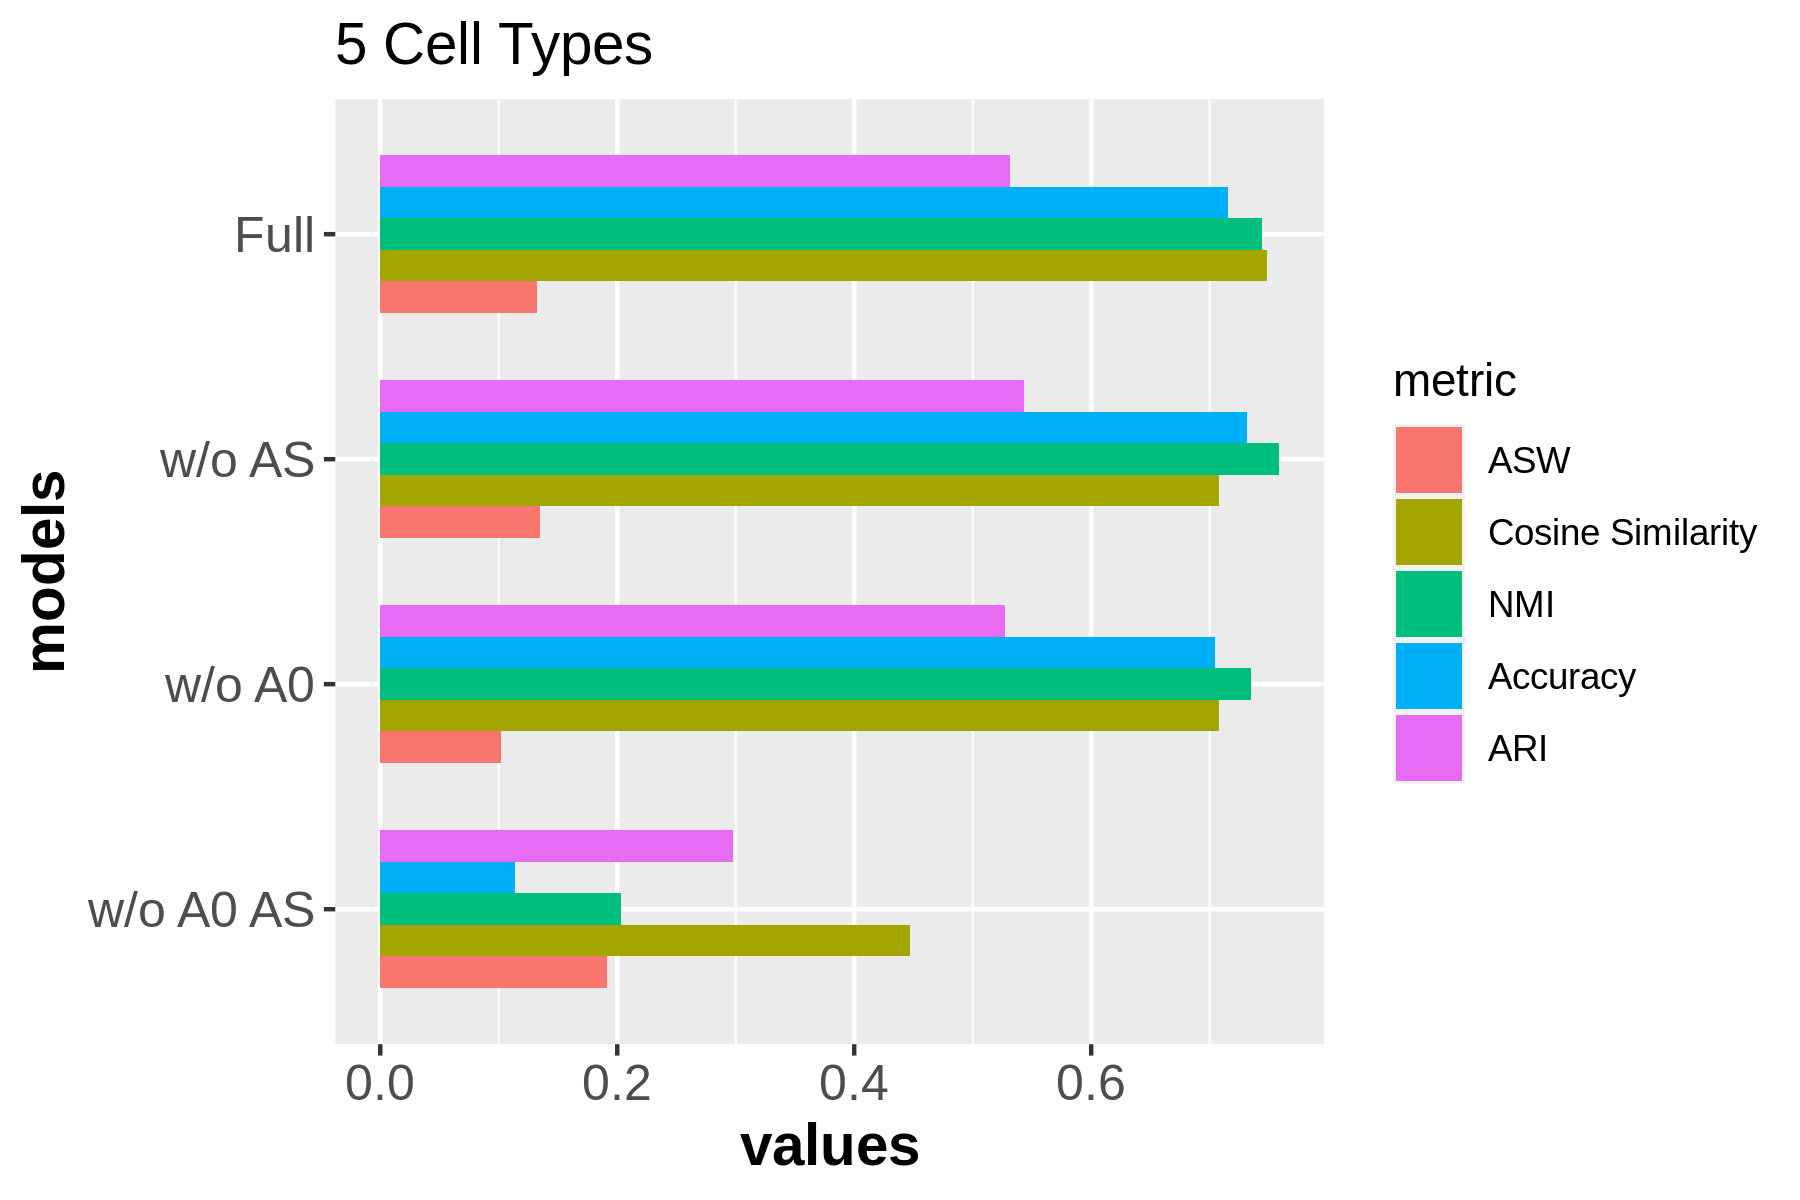

In [82]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 300)
ggplot(data = pars_5, aes(x = models, y = vars, fill = metric, width=.7)) +
  geom_bar(stat="identity", position=position_dodge()) +
  labs(y = 'values', title = '5 Cell Types') +
  coord_flip() +
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold"),
        plot.title = element_text(size=14))

In [83]:
seur_files <- list.files(path = '/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/6celltype', 
                         pattern='*seur*', full=T, ignore.case = TRUE)
rst_files <- list.files(path = '/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/6celltype', 
                        pattern='*rst_patient*', full=T, ignore.case = TRUE)
rst_woas_files <- list.files(path = '/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/6celltype', 
                        pattern='*rst_woa0*', full=T, ignore.case = TRUE)
rst_woa0_files <- list.files(path = '/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/6celltype', 
                        pattern='*rst_woa0*', full=T, ignore.case = TRUE)
rst_woa0as_files <- list.files(path = '/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/6celltype', 
                        pattern='*rst_woa0as*', full=T, ignore.case = TRUE)

In [84]:
acc_vec <- acc_vec_woas <- acc_vec_woa0 <- acc_vec_woa0as <- c()
cos_vec <- cos_vec_woas <- cos_vec_woa0 <- cos_vec_woa0as <-c()
nmi_vec <- nmi_vec_woas <- nmi_vec_woa0 <- nmi_vec_woa0as <- c()
ari_vec <- ari_vec_woas <- ari_vec_woa0 <- ari_vec_woa0as <- c()
sil_vec <- sil_vec_woas <- sil_vec_woa0 <- sil_vec_woa0as <- c()

In [85]:
seur <- readRDS(seur_files[1])
truth <- seur$label
truth_onehot <- as.data.frame(t(one_hot(as.data.table(as.factor(truth)))))
truth_onehot

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V2773,V2774,V2775,V2776,V2777,V2778,V2779,V2780,V2781,V2782
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
V1_CD4 T-cells,1,1,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,1,1,0
V1_CD8 T-cells,0,0,0,0,1,1,1,0,1,1,⋯,1,1,1,1,0,0,0,0,0,0
V1_memory B cells,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
V1_monocytes,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
V1_naïve B cells,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
V1_NK cells,0,0,1,0,0,0,0,1,0,0,⋯,0,0,0,0,1,1,0,0,0,1


In [86]:
for(sample.idx in 1:length(rst_files)){
    rst <- readRDS(rst_files[sample.idx])
    rst_woas <- readRDS(rst_woas_files[sample.idx])
    rst_woa0 <- readRDS(rst_woa0_files[sample.idx])
    rst_woa0as <- readRDS(rst_woa0as_files[sample.idx])
    
    seur <- readRDS(seur_files[sample.idx])
    truth <- seur$label
    pred <- seur$pred
    pred_woas <- seur$pred_woas
    pred_woa0 <- seur$pred_woa0
    pred_woa0as <- seur$pred_woa0as
    
    H <- rst$H
    H_woas <- rst_woas$H
    H_woa0 <- rst_woa0$H
    H_woa0as <- rst_woa0as$H
    
    rownames(H) <- H[,1]
    rownames(H_woas) <- H_woas[,1]
    rownames(H_woa0) <- H_woa0[,1]
    rownames(H_woa0as) <- H_woa0as[,1]
    
    H <- H[,-1]
    H_woas <- H_woas[,-1]
    H_woa0 <- H_woa0[,-1]
    H_woa0as <- H_woa0as[,-1]
    
    celltypes <- c('CD4 T-cells', 'CD8 T-cells', 'memory B cells', 'monocytes', 'naïve B cells', 'NK cells')
    H <- H[celltypes,]
    H_woas <- H_woas[celltypes,]
    H_woa0 <- H_woa0[celltypes,]
    H_woa0as <- H_woa0as[celltypes,]
    
    truth_onehot <- as.data.frame(t(one_hot(as.data.table(as.factor(truth)))))
    pred_fac <- as.factor(pred)
    pred_fac_woas <- as.factor(pred_woas)
    pred_fac_woa0 <- as.factor(pred_woa0)
    pred_fac_woa0as <- as.factor(pred_woa0as)
    pred_onehot <- as.data.frame(t(one_hot(as.data.table(factor(pred_fac, levels = celltypes)))))
    pred_onehot_woas <- as.data.frame(t(one_hot(as.data.table(factor(pred_fac_woas, levels = celltypes)))))
    pred_onehot_woa0 <- as.data.frame(t(one_hot(as.data.table(factor(pred_fac_woa0, levels = celltypes)))))
    pred_onehot_woa0as <- as.data.frame(t(one_hot(as.data.table(factor(pred_fac_woa0as, levels = celltypes)))))
    
    ## raw 
    # Accuracy
    cnt_max <- cnt_max_woas <- cnt_max_woa0 <- cnt_max_woa0as <- 0
    N = ncol(seur)
    for(i in 1:length(truth)){
        cnt_max = cnt_max + 1*(truth[i]==pred[i])
        cnt_max_woas = cnt_max_woas + 1*(truth[i]==pred_woas[i])
        cnt_max_woa0 = cnt_max_woa0 + 1*(truth[i]==pred_woa0[i])
        cnt_max_woa0as = cnt_max_woa0as + 1*(truth[i]==pred_woa0as[i])
    }
    print(paste0(rst_files[sample.idx]," : ", cnt_max))
    print(cnt_max/N)
    acc_vec <- append(acc_vec,cnt_max/N)
    acc_vec_woas <- append(acc_vec_woas,cnt_max_woas/N)
    acc_vec_woa0 <- append(acc_vec_woa0,cnt_max_woa0/N)
    acc_vec_woa0as <- append(acc_vec_woa0as,cnt_max_woa0as/N)
    
    # Cosine similarity
    cos_vec <- append(cos_vec, mean(mapply(cosine, truth_onehot, as.data.frame(H))))
    cos_vec_woas <- append(cos_vec_woas, mean(mapply(cosine, truth_onehot, as.data.frame(H_woas))))
    cos_vec_woa0 <- append(cos_vec_woa0, mean(mapply(cosine, truth_onehot, as.data.frame(H_woa0))))
    cos_vec_woa0as <- append(cos_vec_woa0as, mean(mapply(cosine, truth_onehot, as.data.frame(H_woa0as))))
    
    # NMI
    nmi_vec <- append(nmi_vec, mean(mapply(NMI, truth_onehot, as.data.frame(pred_onehot))))
    nmi_vec_woas <- append(nmi_vec_woas, mean(mapply(NMI, truth_onehot, as.data.frame(pred_onehot_woas))))
    nmi_vec_woa0 <- append(nmi_vec_woa0, mean(mapply(NMI, truth_onehot, as.data.frame(pred_onehot_woa0))))
    nmi_vec_woa0as <- append(nmi_vec_woa0as, mean(mapply(NMI, truth_onehot, as.data.frame(pred_onehot_woa0as))))
    
    # ARI
    ari_vec <- append(ari_vec, adjustedRandIndex(pred, truth))
    ari_vec_woas <- append(ari_vec_woas, adjustedRandIndex(pred_woas, truth))
    ari_vec_woa0 <- append(ari_vec_woa0, adjustedRandIndex(pred_woa0, truth))
    ari_vec_woa0as <- append(ari_vec_woa0as, adjustedRandIndex(pred_woa0as, truth))
    
    # Silhouette
    pca.data <- list()
    pca.data$x <- seur@reductions$pca@cell.embeddings
    pca.data_woas <- list()
    pca.data_woas$x <- seur@reductions$pca@cell.embeddings
    pca.data_woa0 <- list()
    pca.data_woa0$x <- seur@reductions$pca@cell.embeddings
    pca.data_woa0as <- list()
    pca.data_woa0as$x <- seur@reductions$pca@cell.embeddings
    
    sil_vec <- append(sil_vec, batch_sil(pca.data, as.numeric(as.factor(pred))))
    sil_vec_woas <- append(sil_vec_woas, batch_sil(pca.data_woas, as.numeric(as.factor(pred_woas))))
    sil_vec_woa0 <- append(sil_vec_woa0, batch_sil(pca.data_woa0, as.numeric(as.factor(pred_woa0))))
    sil_vec_woa0as <- append(sil_vec_woa0as, batch_sil(pca.data_woa0as, as.numeric(as.factor(pred_woa0as))))                                 
}

[1] "/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/6celltype/rst_patient1_BCR-XL.rds : 2232"
[1] 0.8023005
[1] "/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/6celltype/rst_patient1_Reference.rds : 2148"
[1] 0.8084306
[1] "/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/6celltype/rst_patient2_BCR-XL.rds : 12385"
[1] 0.764459
[1] "/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/6celltype/rst_patient2_Reference.rds : 10477"
[1] 0.6483292
[1] "/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/6celltype/rst_patient3_BCR-XL.rds : 4709"
[1] 0.3995079
[1] "/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/6celltype/rst_patient3_Reference.rds : 4828"
[1] 0.5289799
[1] "/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/6celltype/rst_patient4_BCR-XL.rds : 5556"
[1] 0.63965
[1] "/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/6celltype/rst_patient4_Reference.rds : 2962"
[1] 0.4400535
[1] "/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/6

In [87]:
pars_6 <- data.frame(
    models = c(rep('Full', 5), rep('w/o AS', 5), rep('w/o A0', 5), rep('w/o A0 AS', 5)),
    vars = c(mean(acc_vec), mean(ari_vec), mean(cos_vec), mean(nmi_vec), mean(sil_vec), 
             mean(acc_vec_woas), mean(ari_vec_woas), mean(cos_vec_woas), mean(nmi_vec_woas), mean(sil_vec_woas),
             mean(acc_vec_woa0), mean(ari_vec_woa0), mean(cos_vec_woa0), mean(nmi_vec_woa0), mean(sil_vec_woa0),
             mean(acc_vec_woa0as), mean(ari_vec_woa0as), mean(cos_vec_woa0as), mean(nmi_vec_woa0as), 
             mean(sil_vec_woa0as)),
    metric = rep(c('Accuracy', 'ARI', 'Cosine Similarity', 'NMI', 'ASW'), 4)
)
pars_6$models <- factor(pars_6$models,levels = c("w/o A0 AS", "w/o A0", "w/o AS", "Full"))
pars_6$metric <- factor(pars_6$metric,levels = c('ASW', 'Cosine Similarity', 'NMI', 'Accuracy', 'ARI'))

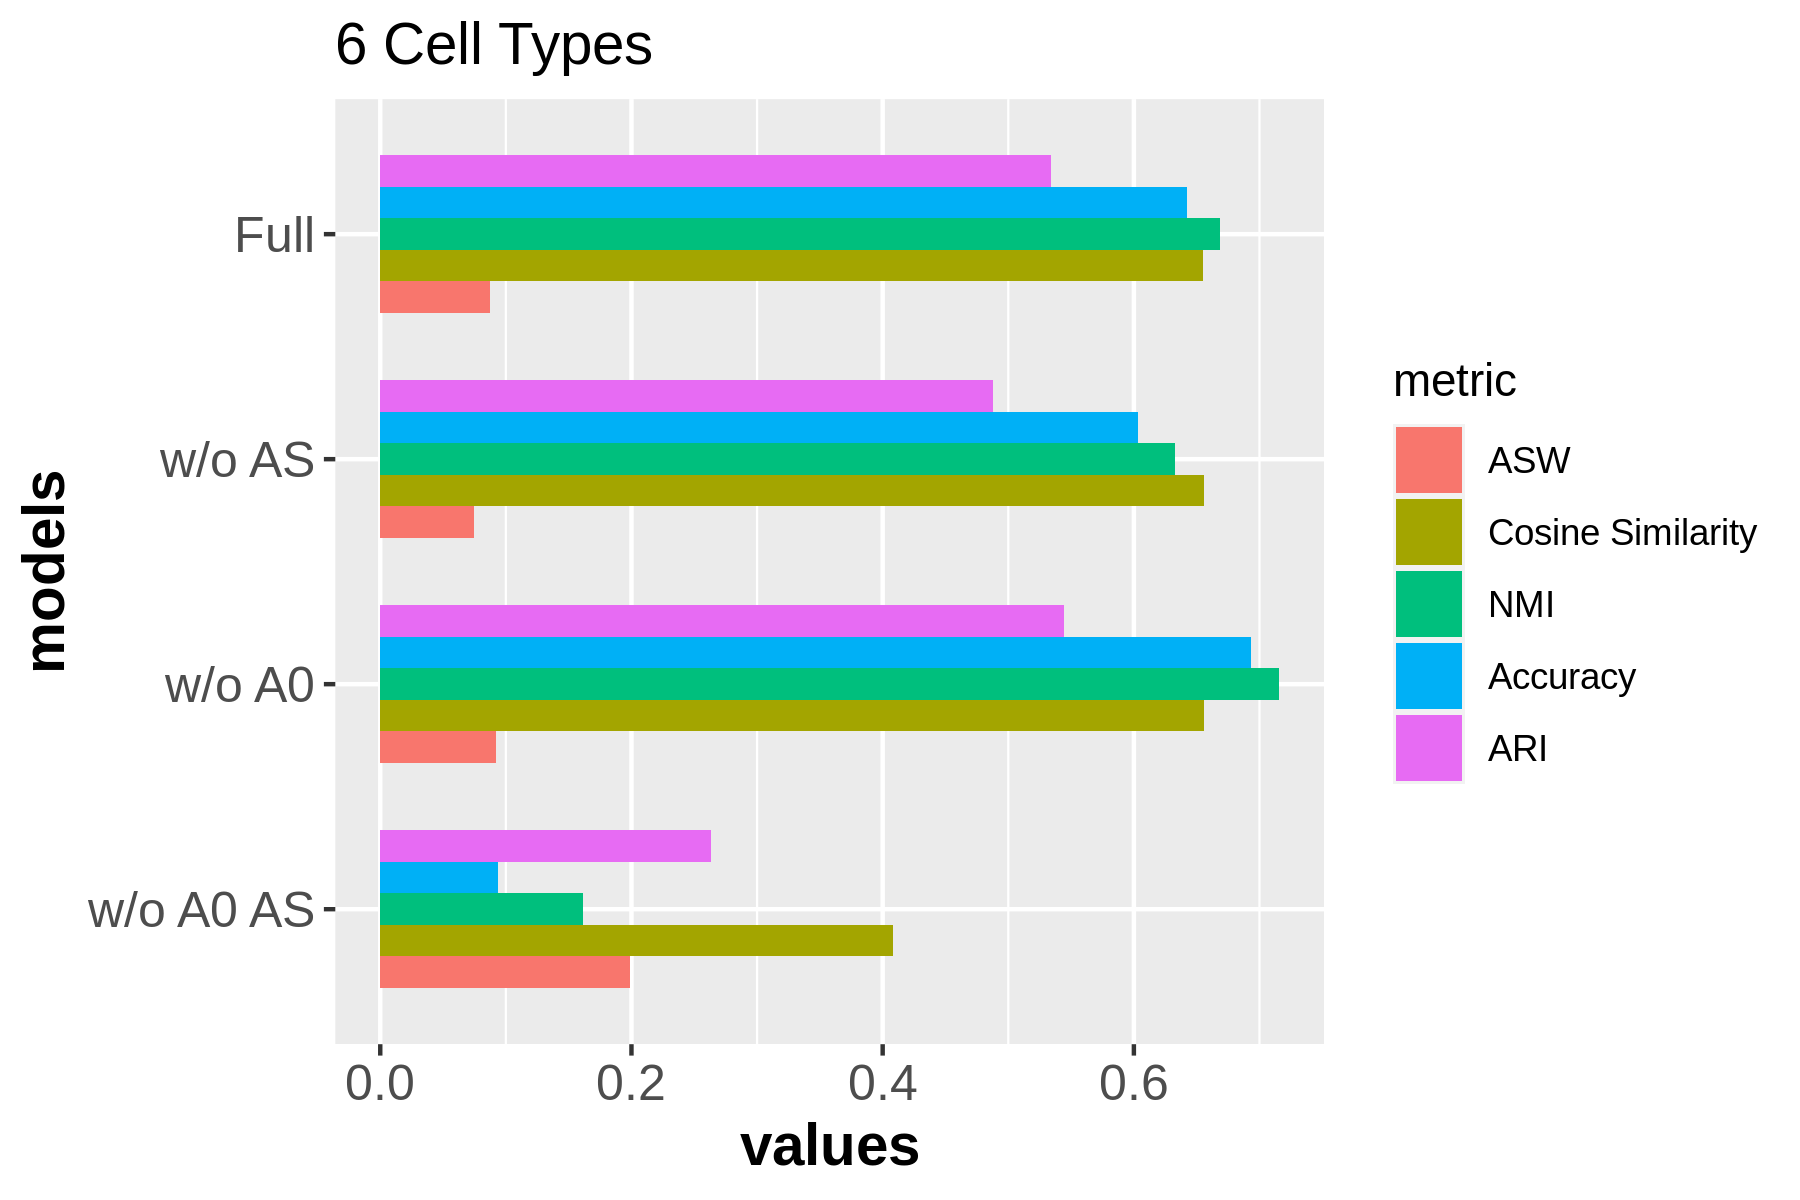

In [88]:
ggplot(data = pars_6, aes(x = models, y = vars, fill = metric, width=.7)) +
  geom_bar(stat="identity", position=position_dodge()) +
  labs(y = 'values', title = '6 Cell Types') +
  coord_flip() +
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold"),
        plot.title = element_text(size=14))

In [89]:
seur_files <- list.files(path = '/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/7celltype', 
                         pattern='*seur*', full=T, ignore.case = TRUE)
rst_files <- list.files(path = '/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/7celltype', 
                        pattern='*rst_patient*', full=T, ignore.case = TRUE)
rst_woas_files <- list.files(path = '/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/7celltype', 
                        pattern='*rst_woa0*', full=T, ignore.case = TRUE)
rst_woa0_files <- list.files(path = '/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/7celltype', 
                        pattern='*rst_woa0*', full=T, ignore.case = TRUE)
rst_woa0as_files <- list.files(path = '/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/7celltype', 
                        pattern='*rst_woa0as*', full=T, ignore.case = TRUE)

In [90]:
acc_vec <- acc_vec_woas <- acc_vec_woa0 <- acc_vec_woa0as <- c()
cos_vec <- cos_vec_woas <- cos_vec_woa0 <- cos_vec_woa0as <-c()
nmi_vec <- nmi_vec_woas <- nmi_vec_woa0 <- nmi_vec_woa0as <- c()
ari_vec <- ari_vec_woas <- ari_vec_woa0 <- ari_vec_woa0as <- c()
sil_vec <- sil_vec_woas <- sil_vec_woa0 <- sil_vec_woa0as <- c()

In [94]:
seur <- readRDS(seur_files[1])
truth <- seur$label
truth_onehot <- as.data.frame(t(one_hot(as.data.table(as.factor(truth)))))
truth_onehot

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V2778,V2779,V2780,V2781,V2782,V2783,V2784,V2785,V2786,V2787
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
V1_CD4 T-cells,1,1,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,1,1,0
V1_CD8 T-cells,0,0,0,0,1,1,1,0,1,1,⋯,1,1,0,1,0,0,0,0,0,0
V1_DC,0,0,0,0,0,0,0,0,0,0,⋯,0,0,1,0,0,0,0,0,0,0
V1_memory B cells,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
V1_monocytes,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
V1_naïve B cells,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
V1_NK cells,0,0,1,0,0,0,0,1,0,0,⋯,0,0,0,0,1,1,0,0,0,1


In [95]:
for(sample.idx in 1:length(rst_files)){
    rst <- readRDS(rst_files[sample.idx])
    rst_woas <- readRDS(rst_woas_files[sample.idx])
    rst_woa0 <- readRDS(rst_woa0_files[sample.idx])
    rst_woa0as <- readRDS(rst_woa0as_files[sample.idx])
    
    seur <- readRDS(seur_files[sample.idx])
    truth <- seur$label
    pred <- seur$pred
    pred_woas <- seur$pred_woas
    pred_woa0 <- seur$pred_woa0
    pred_woa0as <- seur$pred_woa0as
    
    H <- rst$H
    H_woas <- rst_woas$H
    H_woa0 <- rst_woa0$H
    H_woa0as <- rst_woa0as$H
    
    rownames(H) <- H[,1]
    rownames(H_woas) <- H_woas[,1]
    rownames(H_woa0) <- H_woa0[,1]
    rownames(H_woa0as) <- H_woa0as[,1]
    
    H <- H[,-1]
    H_woas <- H_woas[,-1]
    H_woa0 <- H_woa0[,-1]
    H_woa0as <- H_woa0as[,-1]
    
    celltypes <- c('CD4 T-cells', 'CD8 T-cells', 'DC', 'memory B cells', 'monocytes', 'naïve B cells', 'NK cells')
    H <- H[celltypes,]
    H_woas <- H_woas[celltypes,]
    H_woa0 <- H_woa0[celltypes,]
    H_woa0as <- H_woa0as[celltypes,]
    
    truth_onehot <- as.data.frame(t(one_hot(as.data.table(as.factor(truth)))))
    pred_fac <- as.factor(pred)
    pred_fac_woas <- as.factor(pred_woas)
    pred_fac_woa0 <- as.factor(pred_woa0)
    pred_fac_woa0as <- as.factor(pred_woa0as)
    pred_onehot <- as.data.frame(t(one_hot(as.data.table(factor(pred_fac, levels = celltypes)))))
    pred_onehot_woas <- as.data.frame(t(one_hot(as.data.table(factor(pred_fac_woas, levels = celltypes)))))
    pred_onehot_woa0 <- as.data.frame(t(one_hot(as.data.table(factor(pred_fac_woa0, levels = celltypes)))))
    pred_onehot_woa0as <- as.data.frame(t(one_hot(as.data.table(factor(pred_fac_woa0as, levels = celltypes)))))
    
    ## raw 
    # Accuracy
    cnt_max <- cnt_max_woas <- cnt_max_woa0 <- cnt_max_woa0as <- 0
    N = ncol(seur)
    for(i in 1:length(truth)){
        cnt_max = cnt_max + 1*(truth[i]==pred[i])
        cnt_max_woas = cnt_max_woas + 1*(truth[i]==pred_woas[i])
        cnt_max_woa0 = cnt_max_woa0 + 1*(truth[i]==pred_woa0[i])
        cnt_max_woa0as = cnt_max_woa0as + 1*(truth[i]==pred_woa0as[i])
    }
    print(paste0(rst_files[sample.idx]," : ", cnt_max))
    print(cnt_max/N)
    acc_vec <- append(acc_vec,cnt_max/N)
    acc_vec_woas <- append(acc_vec_woas,cnt_max_woas/N)
    acc_vec_woa0 <- append(acc_vec_woa0,cnt_max_woa0/N)
    acc_vec_woa0as <- append(acc_vec_woa0as,cnt_max_woa0as/N)
    
    # Cosine similarity
    cos_vec <- append(cos_vec, mean(mapply(cosine, truth_onehot, as.data.frame(H))))
    cos_vec_woas <- append(cos_vec_woas, mean(mapply(cosine, truth_onehot, as.data.frame(H_woas))))
    cos_vec_woa0 <- append(cos_vec_woa0, mean(mapply(cosine, truth_onehot, as.data.frame(H_woa0))))
    cos_vec_woa0as <- append(cos_vec_woa0as, mean(mapply(cosine, truth_onehot, as.data.frame(H_woa0as))))
    
    # NMI
    nmi_vec <- append(nmi_vec, mean(mapply(NMI, truth_onehot, as.data.frame(pred_onehot))))
    nmi_vec_woas <- append(nmi_vec_woas, mean(mapply(NMI, truth_onehot, as.data.frame(pred_onehot_woas))))
    nmi_vec_woa0 <- append(nmi_vec_woa0, mean(mapply(NMI, truth_onehot, as.data.frame(pred_onehot_woa0))))
    nmi_vec_woa0as <- append(nmi_vec_woa0as, mean(mapply(NMI, truth_onehot, as.data.frame(pred_onehot_woa0as))))
    
    # ARI
    ari_vec <- append(ari_vec, adjustedRandIndex(pred, truth))
    ari_vec_woas <- append(ari_vec_woas, adjustedRandIndex(pred_woas, truth))
    ari_vec_woa0 <- append(ari_vec_woa0, adjustedRandIndex(pred_woa0, truth))
    ari_vec_woa0as <- append(ari_vec_woa0as, adjustedRandIndex(pred_woa0as, truth))
    
    # Silhouette
    pca.data <- list()
    pca.data$x <- seur@reductions$pca@cell.embeddings
    pca.data_woas <- list()
    pca.data_woas$x <- seur@reductions$pca@cell.embeddings
    pca.data_woa0 <- list()
    pca.data_woa0$x <- seur@reductions$pca@cell.embeddings
    pca.data_woa0as <- list()
    pca.data_woa0as$x <- seur@reductions$pca@cell.embeddings
    
    sil_vec <- append(sil_vec, batch_sil(pca.data, as.numeric(as.factor(pred))))
    sil_vec_woas <- append(sil_vec_woas, batch_sil(pca.data_woas, as.numeric(as.factor(pred_woas))))
    sil_vec_woa0 <- append(sil_vec_woa0, batch_sil(pca.data_woa0, as.numeric(as.factor(pred_woa0))))
    sil_vec_woa0as <- append(sil_vec_woa0as, batch_sil(pca.data_woa0as, as.numeric(as.factor(pred_woa0as))))                                 
}

[1] "/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/7celltype/rst_patient1_BCR-XL.rds : 2221"
[1] 0.7969142
[1] "/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/7celltype/rst_patient1_Reference.rds : 1847"
[1] 0.6935787
[1] "/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/7celltype/rst_patient2_BCR-XL.rds : 11956"
[1] 0.7317013
[1] "/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/7celltype/rst_patient2_Reference.rds : 9542"
[1] 0.5850399
[1] "/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/7celltype/rst_patient3_BCR-XL.rds : 7150"
[1] 0.5975263
[1] "/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/7celltype/rst_patient3_Reference.rds : 4983"
[1] 0.539169
[1] "/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/7celltype/rst_patient4_BCR-XL.rds : 6361"
[1] 0.7216109
[1] "/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/7celltype/rst_patient4_Reference.rds : 3309"
[1] 0.4858317
[1] "/home/bz234/project/Results/CyTOF/BCR_Cytof/rst_models/

In [92]:
truth_onehot

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V2778,V2779,V2780,V2781,V2782,V2783,V2784,V2785,V2786,V2787
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
V1_CD4 T-cells,1,1,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,1,1,0
V1_CD8 T-cells,0,0,0,0,1,1,1,0,1,1,⋯,1,1,0,1,0,0,0,0,0,0
V1_DC,0,0,0,0,0,0,0,0,0,0,⋯,0,0,1,0,0,0,0,0,0,0
V1_memory B cells,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
V1_monocytes,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
V1_naïve B cells,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
V1_NK cells,0,0,1,0,0,0,0,1,0,0,⋯,0,0,0,0,1,1,0,0,0,1


In [93]:
as.data.frame(H)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X2778,X2779,X2780,X2781,X2782,X2783,X2784,X2785,X2786,X2787
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CD4 T-cells,1.064258e+00,1.134240e+00,1.241271e-08,6.388720e-01,4.274734e-10,3.364130e-09,1.368407e-01,2.741971e-09,2.085429e-08,5.721914e-12,⋯,3.517800e-05,2.833862e-05,3.668778e-10,8.278657e-05,4.328798e-03,1.669589e-01,5.817562e-01,1.025130e+00,9.282146e-01,4.364210e-07
CD8 T-cells,3.262641e-04,7.836298e-07,4.428202e-02,2.314931e-01,4.338255e-01,6.771893e-01,8.324380e-01,2.284533e-01,4.232254e-01,4.046734e-01,⋯,3.877742e-01,5.901207e-01,3.281549e-01,8.939349e-01,4.580365e-01,3.629598e-01,6.636132e-28,8.809441e-05,1.377937e-01,1.085076e-01
monocytes,8.255978e-36,8.004917e-72,7.040763e-30,1.209676e-65,4.371974e-20,5.649466e-19,2.378414e-24,2.567970e-52,1.148876e-40,4.200748e-12,⋯,3.359298e-14,1.032515e-25,8.860286e-02,3.310233e-13,8.200985e-06,3.330770e-06,3.128602e-01,4.221635e-43,9.228002e-53,3.400615e-23
naïve B cells,1.507168e-28,7.830813e-61,9.566416e-14,2.086649e-48,4.237308e-17,1.860092e-07,5.757117e-22,5.336754e-37,9.355289e-22,6.254630e-01,⋯,3.803432e-01,4.469269e-26,9.270693e-04,1.278652e-13,1.964525e-04,2.182155e-13,4.144472e-04,2.532847e-36,2.137232e-42,5.153334e-14
NK cells,1.439951e-22,2.758697e-09,8.214858e-01,1.561968e-35,5.272244e-01,7.594514e-12,6.771093e-02,8.750785e-01,9.675406e-02,3.066016e-41,⋯,2.642831e-01,4.120483e-01,2.497551e-37,7.749882e-02,5.408098e-01,4.596099e-01,1.033720e-01,5.606760e-02,3.099416e-02,7.460137e-01


In [96]:
pars_7 <- data.frame(
    models = c(rep('Full', 5), rep('w/o AS', 5), rep('w/o A0', 5), rep('w/o A0 AS', 5)),
    vars = c(mean(acc_vec), mean(ari_vec), mean(cos_vec), mean(nmi_vec), mean(sil_vec), 
             mean(acc_vec_woas), mean(ari_vec_woas), mean(cos_vec_woas), mean(nmi_vec_woas), mean(sil_vec_woas),
             mean(acc_vec_woa0), mean(ari_vec_woa0), mean(cos_vec_woa0), mean(nmi_vec_woa0), mean(sil_vec_woa0),
             mean(acc_vec_woa0as), mean(ari_vec_woa0as), mean(cos_vec_woa0as), mean(nmi_vec_woa0as), 
             mean(sil_vec_woa0as)),
    metric = rep(c('Accuracy', 'ARI', 'Cosine Similarity', 'NMI', 'ASW'), 4)
)
pars_7$models <- factor(pars_7$models,levels = c("w/o A0 AS", "w/o A0", "w/o AS", "Full"))
pars_7$metric <- factor(pars_7$metric,levels = c('ASW', 'Cosine Similarity', 'NMI', 'Accuracy', 'ARI'))

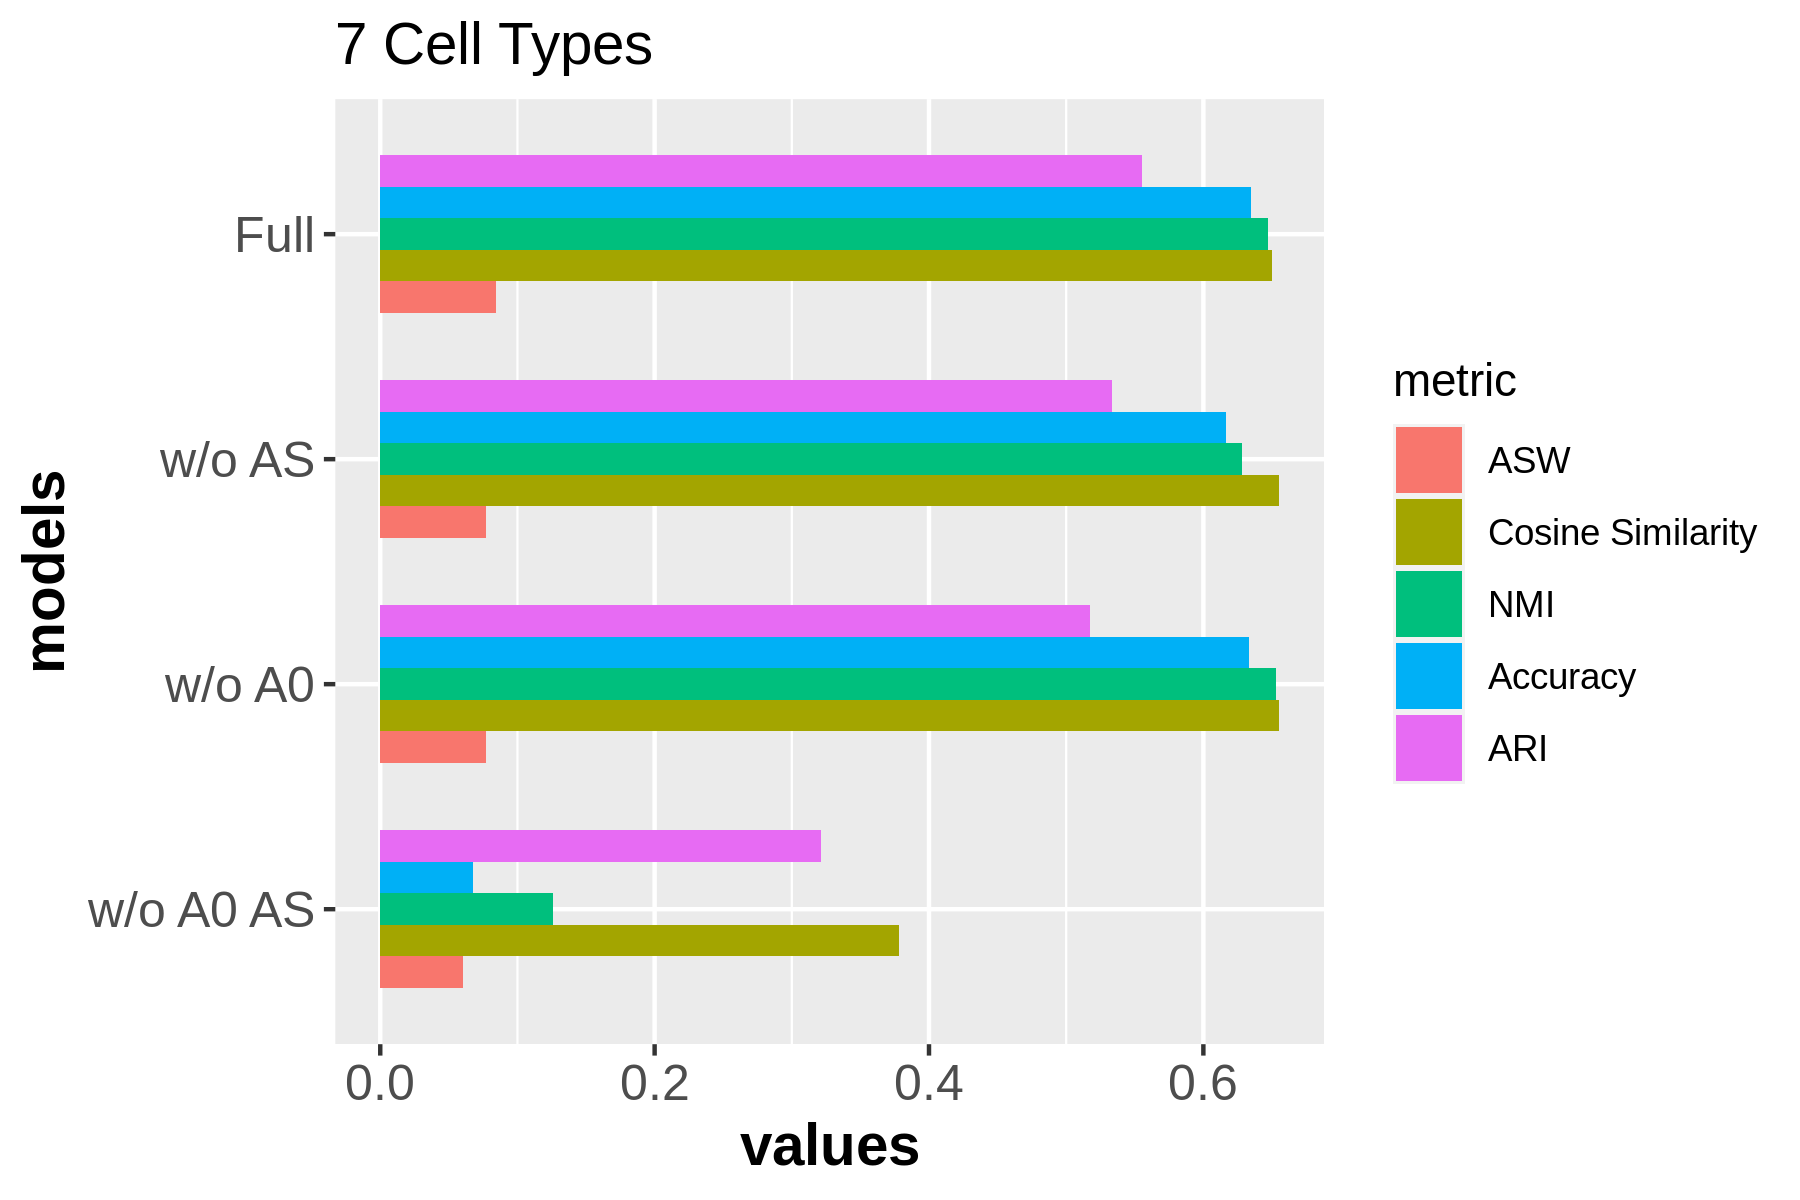

In [97]:
ggplot(data = pars_7, aes(x = models, y = vars, fill = metric, width=.7)) +
  geom_bar(stat="identity", position=position_dodge()) +
  labs(y = 'values', title = '7 Cell Types') +
  coord_flip() +
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold"),
        plot.title = element_text(size=14))